In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pymc as pm
import pymc_bart as pmb
#import theano
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

save_loc = 'C:\\Users\\calvi\\OneDrive\\Desktop\\database\\curry_prop'
os.chdir(save_loc)

In [2]:
def odds_calculator(event_probability):
    if event_probability == 0.5:
        return('+100.0')
    if event_probability > 0.5:
        return('-' + str(100/(1 - event_probability) - 100))
    if event_probability < 0.5:
        return('+' + str(100/event_probability - 100))

# Reading Data

In [5]:
df = pd.read_csv('df_model3.csv', index_col=0)
df.drop(index=df[pd.isnull(df).any(axis=1)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,PPG,Avg_2PA,Avg_3PA,Avg_FTA,3PT_Percentage,True_Shooting_Percentage_Season,Effective_FG_Percentage_Season,TEAM_PPG,TEAM_AVG_PACE,OPP_2PA_AVG,OPP_2P%,OPP_3PA_AVG,OPP_3P%,OPP_FTA_AVG,BestGuardScoringAvg,StephScoringAVGvsOPP,PTS
0,10.400000,6.333333,2.733333,1.733333,0.390244,0.525784,0.500000,108.466667,102.433333,21.500000,0.435216,8.428571,0.381356,9.500000,19.571429,6.000000,7
1,10.176471,6.235294,2.882353,1.647059,0.387755,0.513963,0.487097,109.411765,103.058824,21.277778,0.493473,7.055556,0.370079,7.333333,21.222222,14.000000,11
2,11.333333,6.708333,3.041667,1.875000,0.369863,0.532550,0.502137,106.958333,102.125000,22.318182,0.448065,7.500000,0.339394,7.909091,19.272727,11.000000,8
3,11.807692,6.846154,3.230769,1.884615,0.380952,0.538077,0.507634,106.423077,102.288462,20.703704,0.490161,8.777778,0.413502,7.148148,19.740741,7.000000,14
4,12.071429,6.964286,3.392857,1.821429,0.389474,0.537831,0.508621,106.321429,102.250000,19.333333,0.450000,9.433333,0.353357,7.466667,16.133333,12.000000,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,29.588235,8.745098,11.450980,5.058824,0.428082,0.654635,0.618447,118.194805,102.517403,24.736842,0.524468,16.302632,0.380145,8.605263,23.197368,21.181818,33
832,29.653846,8.769231,11.442308,5.038462,0.431933,0.655919,0.619886,118.346154,102.478718,21.571429,0.527393,17.337662,0.352060,9.467532,22.792208,24.076923,21
833,29.490566,8.867925,11.490566,5.000000,0.425287,0.648615,0.612141,118.240506,102.447342,20.620253,0.516268,18.291139,0.365398,9.594937,22.670886,26.357143,34
834,29.574074,8.925926,11.518519,5.018519,0.426045,0.647752,0.610960,118.462500,102.441750,21.650000,0.518476,16.337500,0.393267,8.800000,23.762500,24.121951,25


# 1. Train/Test Split & Baseline Frequentist Models

In [6]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
#model = LinearRegression()
#model = Lasso()
#model = DecisionTreeRegressor()
model = RandomForestRegressor(random_state=42)
#model = XGBRegressor(random_state=42)

model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [8]:
print(mean_absolute_error(model.predict(X_train), Y_train))
print(mean_absolute_error(model.predict(X_test), Y_test))
print(np.sqrt(mean_squared_error(model.predict(X_train), Y_train)))
print(np.sqrt(mean_squared_error(model.predict(X_test), Y_test)))

2.687230538922156
7.477440476190476
3.4183491962561274
9.256593563766419


# 2. Model Training

## 2.1 Training

In [9]:
with pm.Model() as bart_model:
    X = pm.Data("X", np.array(X_train), mutable=True)
    Y = np.array(Y_train)
    sigma = pm.Normal('sigma', Y.std())
    mu = pmb.BART('mu', X, Y, m=200)
    y = pm.Normal('y', mu, sigma, observed=Y, shape=mu.shape)
    idata_bart_model = pm.sample(2000, tune=1000, chains=4, cores=1, return_inferencedata=True)

Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [sigma]
>PGBART: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 578 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


## 2.2 Model Diagnostics

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

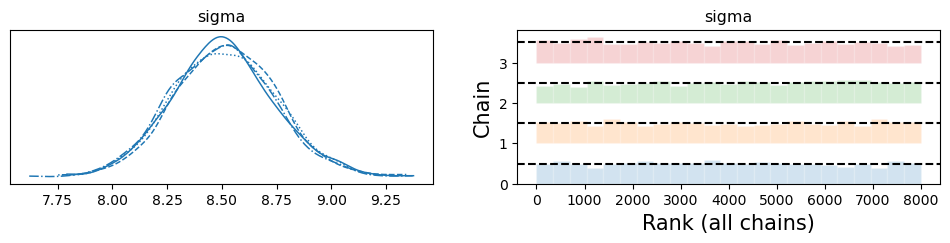

In [10]:
az.plot_trace(idata_bart_model, var_names=["sigma"], kind="rank_bars")

array([<Axes: xlabel='ESS'>, <Axes: xlabel='R-hat'>], dtype=object)

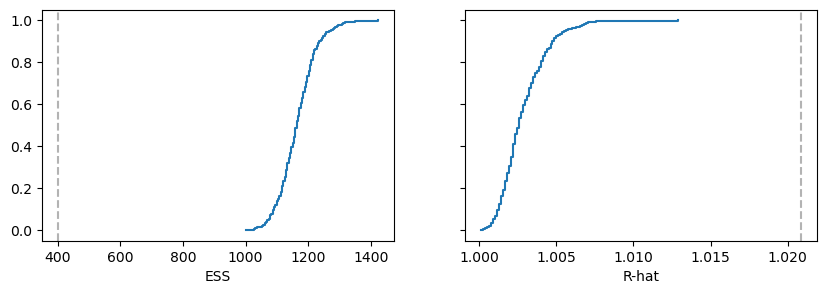

In [11]:
pmb.plot_convergence(idata_bart_model, var_name="mu")

In [12]:
pm.summary(idata_bart_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,8.510,0.235,8.067,8.956,0.005,0.003,2655.0,4433.0,1.0
mu[0],24.887,1.379,22.303,27.478,0.041,0.029,1131.0,2123.0,1.0
mu[1],32.037,1.605,29.055,35.072,0.048,0.034,1137.0,2097.0,1.0
mu[2],32.306,1.354,29.819,34.842,0.040,0.028,1174.0,2193.0,1.0
mu[3],29.753,1.807,26.337,33.136,0.054,0.038,1118.0,1965.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[663],20.572,1.379,17.916,23.099,0.039,0.027,1262.0,2264.0,1.0
mu[664],18.992,1.313,16.606,21.512,0.038,0.027,1168.0,2037.0,1.0
mu[665],24.219,1.406,21.616,26.857,0.041,0.029,1172.0,2112.0,1.0
mu[666],28.093,1.387,25.513,30.686,0.042,0.029,1114.0,2217.0,1.0


# 3. Inference

## 3.1 Training Scores

In [14]:
with bart_model:
    posterior_preds = pm.sample_posterior_predictive(idata_bart_model, model=bart_model, return_inferencedata=False)

Sampling: [y]


In [15]:
posterior_preds['y'].mean(axis=0).mean(axis=0)

array([25.00314168, 32.05618927, 32.48456536, 29.75336609, 26.43012708,
       20.36854454, 14.19963865, 26.37422313, 21.71626644, 24.70872392,
       22.32063623, 26.08040235, 23.35148204, 23.4491619 , 19.47808043,
       25.00284644, 21.65749722, 24.3774526 , 21.39939598, 27.60045462,
       25.7478023 , 29.32870899, 27.82977579, 25.81706163, 29.30144123,
       22.13174495, 22.82286074, 31.8807456 , 21.17296203, 26.74202689,
       30.76420595, 28.33955614, 24.55415264, 28.71897856, 26.7974479 ,
       31.00534648, 26.74257226, 24.2853419 , 24.57717494, 24.55100538,
       18.43015774, 27.91273175, 23.30851491, 30.12413255, 26.44490423,
       28.25752413, 22.77809587, 16.78959098, 28.81142793, 17.64906855,
       25.86044265, 21.0999243 , 17.87009665, 32.22549341, 28.96647362,
       21.54610173, 29.72102231, 19.17592085, 18.47224448, 21.83017387,
       21.18432403, 22.52488549, 29.40402074, 24.27892395, 27.35936043,
       30.73649039, 22.14992854, 18.59316854, 29.58398708, 29.07

In [16]:
y_pred_mean = posterior_preds['y'].mean(axis=0).mean(axis=0)
y_pred_median = np.median(np.median(posterior_preds['y'], axis=0), axis=0)

In [17]:
print('RMSE TRAIN MEAN : {}'.format(np.sqrt(mean_squared_error(Y_train, y_pred_mean))))
print('MAE TRAIN MEAN : {}'.format(mean_absolute_error(Y_train, y_pred_mean)))
print('RMSE TRAIN MEDIAN : {}'.format(np.sqrt(mean_squared_error(Y_train, y_pred_median))))
print('MAE TRAIN MEDIAN : {}'.format(mean_absolute_error(Y_train, y_pred_median)))

RMSE TRAIN MEAN : 8.304597195975271
MAE TRAIN MEAN : 6.525749411653065
RMSE TRAIN MEDIAN : 8.308640453933902
MAE TRAIN MEDIAN : 6.53014970143366


## 3.2 Test Score

In [18]:
with bart_model:
    X.set_value(X_test)
    posterior_predictive_test = pm.sample_posterior_predictive(idata_bart_model, model=bart_model, return_inferencedata=False)

Sampling: [mu, y]


In [19]:
y_pred_mean_test = posterior_predictive_test['y'].mean(axis=0).mean(axis=0)
y_pred_median_test = np.median(np.median(posterior_predictive_test['y'], axis=0), axis=0)

In [20]:
print('RMSE TEST MEAN : {}'.format(np.sqrt(mean_squared_error(Y_test, y_pred_mean_test))))
print('MAE TEST MEAN : {}'.format(mean_absolute_error(Y_test, y_pred_mean_test)))
print('RMSE TEST MEDIAN : {}'.format(np.sqrt(mean_squared_error(Y_test, y_pred_median_test))))
print('MAE TEST MEDIAN : {}'.format(mean_absolute_error(Y_test, y_pred_median_test)))

RMSE TEST MEAN : 8.945603541287344
MAE TEST MEAN : 7.220035566191309
RMSE TEST MEDIAN : 8.946738841503159
MAE TEST MEDIAN : 7.22197840040521


# 4. Predicting on Single Out of Sample/Betting Line

In [31]:
# Grabbing a single datapoint to make predictions and create a point total player player prop line
sample_input = np.array([X_test.iloc[-1, :].values])

In [32]:
sample_input

array([[ 25.90909091,   7.72727273,   9.68181818,   5.31818182,
          0.40375587,   0.64983184,   0.60313316, 119.95454545,
        101.13863636,  22.17391304,   0.4372549 ,  10.        ,
          0.36956522,   7.43478261,  19.95652174,  22.13636364]])

In [33]:
with bart_model:
    X.set_value(sample_input)
    posterior_predictive_point = pm.sample_posterior_predictive(idata_bart_model, model=bart_model, return_inferencedata=False)

Sampling: [mu, y]


In [34]:
posterior_preds_point = posterior_predictive_point['y'].mean(axis=0)

In [38]:
point_value = 24.5
points_prob = len(posterior_preds_point[posterior_preds_point > point_value]) / len(posterior_preds_point)
print('Probability of Steph scoring more than {} : {}'.format(point_value, points_prob))
print('Player Prop Betting Line : {}'.format(odds_calculator(points_prob)))

Probability of Steph scoring more than 24.5 : 0.5025
Player Prop Betting Line : -101.00502512562812


In [36]:
np.median(posterior_predictive_point['y'].mean(axis=0))

24.530793475037893

In [39]:
# How much did Steph actually score that night?
Y_test.iloc[-1]

26

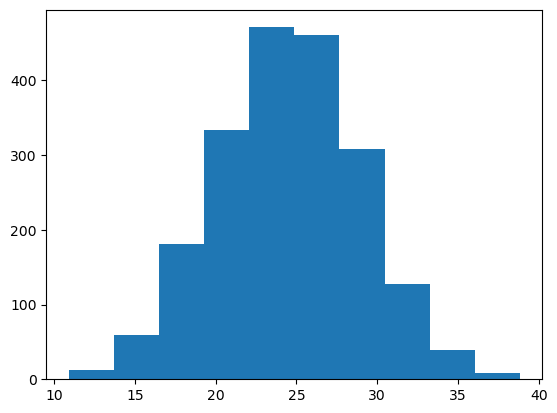

In [40]:
plt.hist(posterior_predictive_point['y'].mean(axis=0))
plt.show()